In [48]:
import numpy as np
import random
from collections import deque
import torch
import torch.nn as nn
import torch.optim as optim
import openai

In [ ]:
# Hyperparameters
N = 10              # Number of channels
L = 2               # Number of channels sensed at a time
H = 6               # History length
AEX_SIZE = (N * N) // L  # Extended action space size
STATE_SIZE = N * H
MEMORY_SIZE = 30000
BATCH_SIZE = 64
GAMMA = 0.8
LR = 1e-4
EPSILON_DECAY = 0.001
TARGET_UPDATE = 20

**Experience Replay Buffer**

In [ ]:
class ReplayBuffer:
    def __init__(self, max_size):
        self.buffer = deque(maxlen=max_size)

    def push(self, state, action, reward, next_state):
        self.buffer.append((state, action, reward, next_state))

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)

**Deep Q-Network**

In [ ]:
class QNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.out = nn.Linear(128, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.out(x)

**LLM FUNCTION**

In [55]:
# !pip install openai python-dotenv --quiet
# import openai
import openai
openai.api_key = input("use new api key while again running")

In [49]:
class LLM:
    def __init__(self, api_key):
        # openai.api_key = api_key
        if not openai.api_key:
            raise ValueError("API key missing.")
        self.client = openai.OpenAI(api_key=api_key)


    def adjust_hyperparams(self, state_summary, reward, epsilon, gamma):
        prompt = (
            f"The agent observed average state={state_summary:.2f} and got reward={reward}.\n"
            f"Current epsilon={epsilon:.4f}, gamma={gamma:.2f}.\n"
            "Should epsilon be higher/lower? Should gamma be increased? Return JSON only."
        )
        try:
            response = self.client.chat.completions.create(
                model="gpt-4o",
                messages=[{"role": "user", "content": prompt}]
            )
            content = response.choices[0].message.content
            suggestion = eval(content.strip())  # Unsafe in prod; replace with json.loads
            return suggestion.get("epsilon", epsilon), suggestion.get("gamma", gamma)
        except Exception as e:
            print("LLM error:", e)
            return epsilon, gamma

**DDQSA Agent**

In [50]:
class DDQSAAgent:
    def __init__(self, llm=None):
        self.policy_net = QNetwork(STATE_SIZE, AEX_SIZE).to('cpu')
        self.target_net = QNetwork(STATE_SIZE, AEX_SIZE).to('cpu')
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=LR)
        self.memory = ReplayBuffer(MEMORY_SIZE)
        self.steps = 0
        self.t_transmit = 0
        self.epsilon = 1.0
        self.gamma = GAMMA
        self.llm = llm

    def select_action(self, state):
        if random.random() > self.epsilon:
            with torch.no_grad():
                state_tensor = torch.FloatTensor(state).unsqueeze(0)
                return self.policy_net(state_tensor).argmax().item()
        else:
            return random.randint(0, AEX_SIZE - 1)

    def optimize(self):
        if len(self.memory) < BATCH_SIZE:
            return

        batch = self.memory.sample(BATCH_SIZE)
        state, action, reward, next_state = zip(*batch)

        state = torch.FloatTensor(np.array(state))
        next_state = torch.FloatTensor(np.array(next_state))
        action = torch.LongTensor(action).unsqueeze(1)
        reward = torch.FloatTensor(reward).unsqueeze(1)

        q_values = self.policy_net(state).gather(1, action)
        with torch.no_grad():
            next_actions = self.policy_net(next_state).argmax(1, keepdim=True)
            q_target = reward + self.gamma * self.target_net(next_state).gather(1, next_actions)

        loss = nn.SmoothL1Loss()(q_values, q_target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        if self.steps % TARGET_UPDATE == 0:
            self.target_net.load_state_dict(self.policy_net.state_dict())

    def remember(self, state, action, reward, next_state):
        self.memory.push(state, action, reward, next_state)

    def llm_adjust(self, state, reward):
        if self.llm and self.steps % 10 == 0:
            avg_state = np.mean(state)
            self.epsilon, self.gamma = self.llm.adjust_hyperparams(avg_state, reward, self.epsilon, self.gamma)

In [ ]:
# Simulated Environment
def simulate_environment_step(state, action_index):
    next_state = np.random.choice([-1, 0, 1], STATE_SIZE)
    reward = np.random.choice([-1, 1], p=[0.4, 0.6])
    return next_state, reward

In [ ]:
# pip install openai==0.28
from dotenv import load_dotenv
import os
import openai

**Training the Loop**

In [52]:
llm = LLM(openai.api_key)
agent = DDQSAAgent(llm=llm)
state = np.random.choice([-1, 0, 1], STATE_SIZE)

for t in range(300):
    action = agent.select_action(state)
    next_state, reward = simulate_environment_step(state, action)
    agent.remember(state, action, reward, next_state)

    if reward != 0:
        agent.t_transmit += 1

    if len(agent.memory) > BATCH_SIZE:
        agent.optimize()

    agent.llm_adjust(state, reward)

    if t % 50 == 0:
        print(f"Step {t}, Reward: {reward}, Epsilon: {agent.epsilon:.4f}, Gamma: {agent.gamma:.2f}")

    state = next_state
    agent.steps += 1

LLM error: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}
Step 0, Reward: 1, Epsilon: 1.0000, Gamma: 0.80
LLM error: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}
LLM error: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insuffic

In [53]:
rewards = []

for t in range(300):
    action = agent.select_action(state)
    next_state, reward = simulate_environment_step(state, action)
    agent.remember(state, action, reward, next_state)

    if reward != 0:
        agent.t_transmit += 1

    if len(agent.memory) > BATCH_SIZE:
        agent.optimize()

    agent.llm_adjust(state, reward)

    rewards.append(reward)  # this tracks reward

    if t % 50 == 0:
        print(f"Step {t}, Reward: {reward}, Epsilon: {agent.epsilon:.4f}, Gamma: {agent.gamma:.2f}")

    state = next_state
    agent.steps += 1

LLM error: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}
Step 0, Reward: -1, Epsilon: 1.0000, Gamma: 0.80
LLM error: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}
LLM error: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insuffi

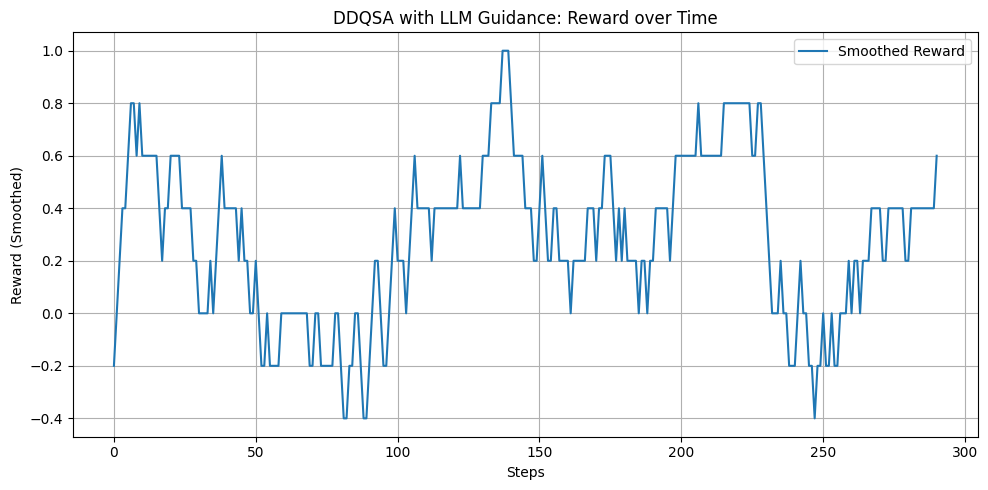

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

def moving_average(x, w=10):
    return np.convolve(x, np.ones(w), 'valid') / w

plt.figure(figsize=(10, 5))
plt.plot(moving_average(rewards), label='Smoothed Reward')
plt.xlabel("Steps")
plt.ylabel("Reward (Smoothed)")
plt.title("DDQSA with LLM Guidance: Reward over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Now here we are trying to compare the DDQSA agent performance with and without LLM to have a better throughput tracking.

In [ ]:
class DDQSAAgent:
    def __init__(self, use_llm=False):
        self.policy_net = QNetwork(STATE_SIZE, AEX_SIZE)
        self.target_net = QNetwork(STATE_SIZE, AEX_SIZE)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=LR)
        self.memory = ReplayBuffer(MEMORY_SIZE)
        self.steps = 0
        self.t_transmit = 0
        self.epsilon = 1.0
        self.gamma = 0.8
        self.use_llm = use_llm

    def select_action(self, state):
        if random.random() > self.epsilon:
            with torch.no_grad():
                return self.policy_net(torch.FloatTensor(state)).argmax().item()
        else:
            return random.randint(0, AEX_SIZE - 1)

    def optimize(self):
        if len(self.memory) < BATCH_SIZE:
            return

        batch = self.memory.sample(BATCH_SIZE)
        state, action, reward, next_state = zip(*batch)
        state = torch.FloatTensor(np.array(state))
        next_state = torch.FloatTensor(np.array(next_state))
        action = torch.LongTensor(action).unsqueeze(1)
        reward = torch.FloatTensor(reward).unsqueeze(1)

        q_values = self.policy_net(state).gather(1, action)
        with torch.no_grad():
            next_actions = self.policy_net(next_state).argmax(1, keepdim=True)
            q_target = reward + self.gamma * self.target_net(next_state).gather(1, next_actions)

        loss = nn.SmoothL1Loss()(q_values, q_target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        if self.steps % TARGET_UPDATE == 0:
            self.target_net.load_state_dict(self.policy_net.state_dict())

    def remember(self, state, action, reward, next_state):
        self.memory.push(state, action, reward, next_state)

    def llm_adjust(self, state, reward):
        # Simulated logic instead of OpenAI call
        if self.use_llm and self.steps % 10 == 0:
            avg = np.mean(state)
            if reward < 0:
                self.epsilon = max(0.01, self.epsilon * 0.95)
            if avg > 0:
                self.gamma = min(0.99, self.gamma + 0.01)


In [ ]:
def run_training(agent, steps=300):
    rewards = []
    state = np.random.choice([-1, 0, 1], STATE_SIZE)
    for t in range(steps):
        action = agent.select_action(state)
        next_state, reward = simulate_environment_step(state, action)
        agent.remember(state, action, reward, next_state)

        if reward != 0:
            agent.t_transmit += 1

        if len(agent.memory) > BATCH_SIZE:
            agent.optimize()

        agent.llm_adjust(state, reward)
        rewards.append(reward)
        state = next_state
        agent.steps += 1
    return rewards

# Moving average
def moving_average(x, w=10):
    return np.convolve(x, np.ones(w), 'valid') / w


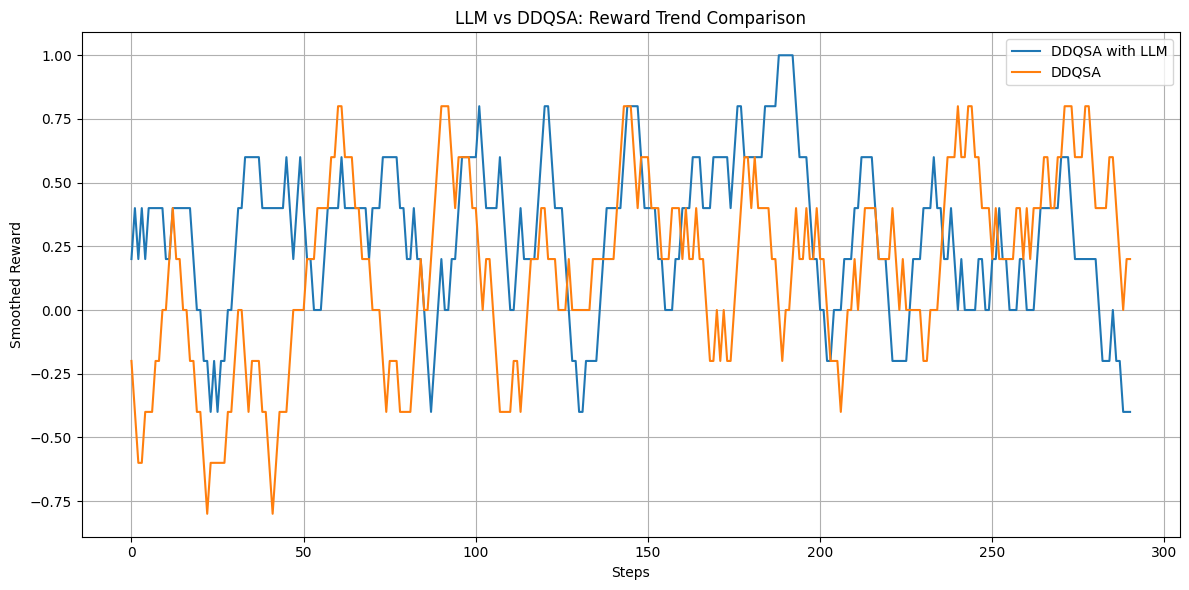

In [ ]:
agent_llm = DDQSAAgent(use_llm=True)
agent_nollm = DDQSAAgent(use_llm=False)

rewards_llm = run_training(agent_llm)
rewards_base = run_training(agent_nollm)

plt.figure(figsize=(12, 6))
plt.plot(moving_average(rewards_llm), label='DDQSA with LLM')
plt.plot(moving_average(rewards_base), label='DDQSA')
plt.xlabel('Steps')
plt.ylabel('Smoothed Reward')
plt.title('LLM vs DDQSA: Reward Trend Comparison')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
